<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Deep_Learning_Second_Hand_Dataset_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 0.4229198396205902
Epoch 20, Loss: 0.03878188505768776
Epoch 40, Loss: 0.016401059925556183
Epoch 60, Loss: 0.007562161888927221
Epoch 80, Loss: 0.005508142057806253
Epoch 100, Loss: 0.004895444959402084
Epoch 120, Loss: 0.004358710255473852
Epoch 140, Loss: 0.0038782123010605574
Epoch 160, Loss: 0.003461891785264015
Epoch 180, Loss: 0.0030901620630174875
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- 📊 Perbandingan Evaluasi Model ---
🔹 MSE PyTorch: 1132735667.4925, TensorFlow: 685391720.2841
🔹 RMSE PyTorch: 33656.1386, TensorFlow: 26179.9870
🔹 R-Squared PyTorch: 0.9326, TensorFlow: 0.9592


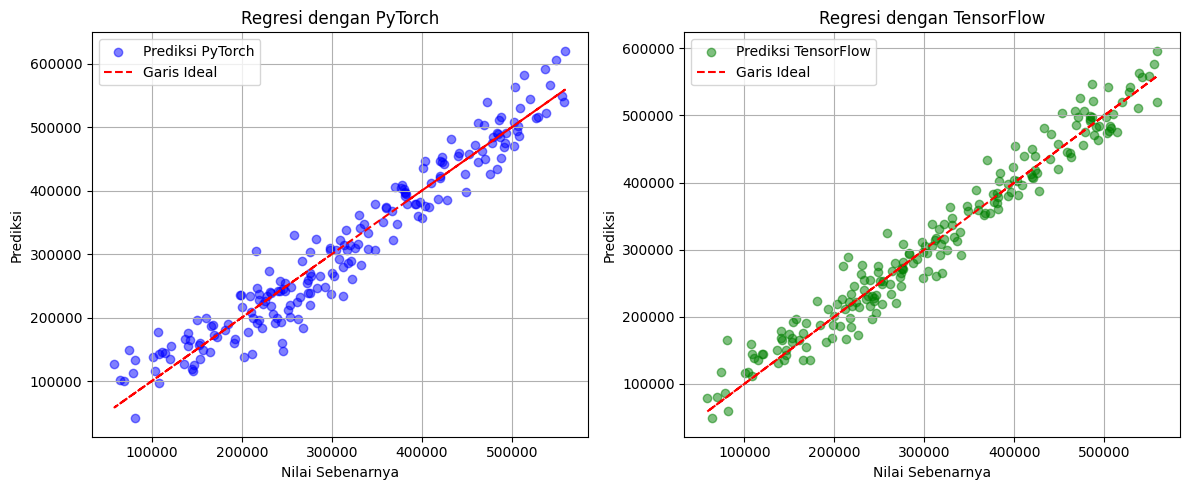

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

#  **1. Memuat Dataset**
data_path = '/content/drive/MyDrive/Deep Learning/secondhanddataset.csv'
df = pd.read_csv(data_path)

# Mengambil kolom terakhir sebagai target
kolom_target = df.columns[-1]
X = df.drop(columns=[kolom_target])
y = df[kolom_target]

# Normalisasi target menggunakan MinMaxScaler
skaler_y = MinMaxScaler()
y = skaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Membagi dataset menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur menggunakan StandardScaler
skaler_X = StandardScaler()
X_train = skaler_X.fit_transform(X_train)
X_test = skaler_X.transform(X_test)

# Konversi data menjadi tensor untuk PyTorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#  **2. Definisi Model MLP dengan PyTorch**
class MLP_Torch(nn.Module):
    def __init__(self, input_size):
        super(MLP_Torch, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Layer pertama dengan 128 neuron
        self.leaky_relu = nn.LeakyReLU()  # Aktivasi LeakyReLU
        self.fc2 = nn.Linear(128, 64)  # Layer kedua dengan 64 neuron
        self.fc3 = nn.Linear(64, 1)  # Layer output dengan 1 neuron

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inisialisasi model PyTorch
model_torch = MLP_Torch(X_train.shape[1])
criterion = nn.MSELoss()  # Fungsi loss menggunakan Mean Squared Error
optimizer = optim.Adam(model_torch.parameters(), lr=0.0005)  # Optimizer Adam

# Training model PyTorch
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model_torch(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluasi model PyTorch
y_pred_torch = model_torch(X_test_torch).detach().numpy()
y_pred_torch = skaler_y.inverse_transform(y_pred_torch)  # Mengembalikan ke skala asli
y_test_asli = skaler_y.inverse_transform(y_test.reshape(-1, 1))

# Menyimpan metrik evaluasi PyTorch
metrik_torch = {
    "MSE": mean_squared_error(y_test_asli, y_pred_torch),
    "RMSE": np.sqrt(mean_squared_error(y_test_asli, y_pred_torch)),
    "R-Squared": r2_score(y_test_asli, y_pred_torch),
}

#  **3. Definisi Model MLP dengan TensorFlow**
model_tf = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Layer input
    keras.layers.Dense(128, activation='relu'),  # Layer pertama dengan 128 neuron
    keras.layers.Dense(64, activation='relu'),  # Layer kedua dengan 64 neuron
    keras.layers.Dense(1)  # Layer output dengan 1 neuron
])

# Menggunakan Early Stopping agar training berhenti jika tidak ada peningkatan
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_tf.compile(optimizer='adam', loss='mse')
model_tf.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0, callbacks=[early_stopping])

# Evaluasi model TensorFlow
y_pred_tf = model_tf.predict(X_test)
y_pred_tf = skaler_y.inverse_transform(y_pred_tf)  # Mengembalikan ke skala asli

# Menyimpan metrik evaluasi TensorFlow
metrik_tf = {
    "MSE": mean_squared_error(y_test_asli, y_pred_tf),
    "RMSE": np.sqrt(mean_squared_error(y_test_asli, y_pred_tf)),
    "R-Squared": r2_score(y_test_asli, y_pred_tf),
}

#  **4. Menampilkan Hasil Perbandingan Model**
print("\n--- 📊 Perbandingan Evaluasi Model ---")
for key in metrik_torch.keys():
    print(f"🔹 {key} PyTorch: {metrik_torch[key]:.4f}, TensorFlow: {metrik_tf[key]:.4f}")

#  **5. Visualisasi Hasil Prediksi**
def plot_regresi(ax, y_asli, y_pred, judul, warna, label_prediksi):
    ax.scatter(y_asli, y_pred, alpha=0.5, color=warna, label=label_prediksi)  # Titik prediksi
    ax.plot(y_asli, y_asli, linestyle='--', color='red', label='Garis Ideal')  # Garis ideal (y = x)
    ax.set_xlabel("Nilai Sebenarnya")
    ax.set_ylabel("Prediksi")
    ax.set_title(judul)
    ax.legend()
    ax.grid(True)

# 🔹 **Membuat dua subplot berdampingan**
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 **Plot untuk PyTorch**
plot_regresi(axes[0], y_test_original, y_pred_torch, "Regresi dengan PyTorch", "blue", "Prediksi PyTorch")

# 🔹 **Plot untuk TensorFlow**
plot_regresi(axes[1], y_test_original, y_pred_tf, "Regresi dengan TensorFlow", "green", "Prediksi TensorFlow")

# 🔹 **Menampilkan hasil**
plt.tight_layout()
plt.show()




# 📌 Evaluasi Model: RMSE, MSE, dan R-Squared  



---

##  1. Mean Squared Error (MSE)  
Mean Squared Error (MSE) mengukur rata-rata dari kuadrat selisih antara nilai aktual (\($y_i$\)) dan nilai prediksi ($(\hat{y}_i)$).  

\[
$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
\]

- **Semakin kecil nilai MSE, semakin baik modelnya.**  
- MSE peka terhadap outlier karena menggunakan selisih kuadrat.  

---

##  2. Root Mean Squared Error (RMSE)  
Root Mean Squared Error (RMSE) adalah akar kuadrat dari MSE. Metrik ini memiliki satuan yang sama dengan data asli sehingga lebih mudah diinterpretasikan.  

\[
$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
\]

- **Semakin kecil RMSE, semakin baik performa model.**  
- RMSE lebih cocok untuk membandingkan kesalahan model dalam skala yang sama dengan data asli.  

---

##  3. R-Squared (R²) - Koefisien Determinasi  
R-Squared (\($R^2$\)) mengukur seberapa baik model menjelaskan variabilitas dalam data. Nilai \($R^2$\) berkisar antara 0 hingga 1.  

\[
$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
\]

- Jika \( $R^2 = 1 $\), model menjelaskan semua variasi data dengan sempurna.  
- Jika \( $R^2 = 0 $\), model tidak lebih baik daripada rata-rata sebagai prediksi.  
- Nilai negatif \($R^2$\) menunjukkan model lebih buruk daripada rata-rata.  

---

## 📌 Kesimpulan  
- **MSE dan RMSE** digunakan untuk mengukur seberapa besar kesalahan prediksi model dalam satuan kuadrat atau asli.  
- **R-Squared (\($R^2$\))** digunakan untuk mengetahui seberapa baik model menjelaskan variasi dalam data.  
- **Pemilihan metrik tergantung pada kebutuhan:**  
  - Jika ingin menilai **kesalahan absolut**, gunakan **RMSE**.  
  - Jika ingin melihat **kemampuan model menjelaskan data**, gunakan **\($R^2$\)**.  
